In [227]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime as dt
from matplotlib import pyplot as plt
from scipy import stats as st

In [228]:
# This strategy is for TLT.

In [229]:
tlt = yf.Ticker("TLT")
df = tlt.history(period = "max")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2002-07-30,41.352758,41.428635,41.236412,41.236412,6100,0.000,0
2002-07-31,41.453909,41.883879,41.428619,41.747299,29400,0.000,0
2002-08-01,41.752359,41.995162,41.752359,41.985046,25000,0.000,0
2002-08-02,42.065952,42.541443,41.924313,42.414982,52800,0.000,0
2002-08-05,42.511121,42.713459,42.415009,42.602173,61100,0.000,0
...,...,...,...,...,...,...,...
2022-12-13,108.776880,108.816784,107.200691,107.440109,23854700,0.000,0
2022-12-14,107.400209,108.058612,106.632062,107.899002,19517500,0.000,0
2022-12-15,108.389999,109.120003,108.160004,108.320000,20246200,0.261,0


In [230]:
df = df.drop(["High", "Low", "Volume", "Dividends", "Stock Splits"], axis = 1)
df["TLT_diff"] = df["Close"].diff()
df["TLT_premarket_diff_perc"] = ((df["Open"] - df["Close"].shift(1)) / df["Close"])
df["Month"] = df.index.month
df["Day"] = df.index.day
df["buy"] = [0] * len(df)
df["sell"] = [0] * len(df)
df["cover_short"] = [0] * len(df)
#df["cover_short"] = [0] * len(df)
df

,Open,Close,TLT_diff,TLT_premarket_diff_perc,Month,Day,buy,sell,cover_short
Date,,,,,,,,,
2002-07-30,41.352758,41.236412,NaN,NaN,7,30,0,0,0
2002-07-31,41.453909,41.747299,0.510887,0.005210,7,31,0,0,0
2002-08-01,41.752359,41.985046,0.237747,0.000121,8,1,0,0,0
2002-08-02,42.065952,42.414982,0.429935,0.001907,8,2,0,0,0
2002-08-05,42.511121,42.602173,0.187191,0.002257,8,5,0,0,0
...,...,...,...,...,...,...,...,...,...
2022-12-13,108.776880,107.440109,1.027519,0.022006,12,13,0,0,0
2022-12-14,107.400209,107.899002,0.458893,-0.000370,12,14,0,0,0
2022-12-15,108.389999,108.320000,0.420998,0.004533,12,15,0,0,0


In [231]:
type(df.index)  # Date index is DateTime type.

pandas.core.indexes.datetimes.DatetimeIndex

In [232]:
# Set the initial capital
initial_capital= float(10000)

In [233]:
df.loc[
    (
        ((df["Month"] != 2) &  # If month is not February, buy 5 days before end of month (25th day or if weekend 23rd day.)
        ((df["Day"] >= 23) &
        (df["Day"] <= 25))) |
        
        ((df["Month"] == 2) &  # If month is February, buy 5 days before end of month (23rd day or if weekend 21st day.)
        ((df["Day"] >= 21) &
        (df["Day"] <= 23)))
    ),
    
"buy"] = 1

# But this causes adjacent "buy" = 1 values.

df.loc[
    (
 
        ((df["Month"] != 2) &  # If month is not February, sell on last day of month (30th day or if weekend 28th day.)
        (df["Day"] >= 29) &
        (df["Day"] <= 31)) |
        
        ((df["Month"] == 2) &  # If month is February, sell on last day of month (28th day or if weekend 26th day.)
        (df["Day"] >= 26) &
        (df["Day"] <= 28))
    ),
    
"sell"] = 1

# Sell. But this causes adjacent "sell" = 1 values.

df.loc[
    (
        ((df["Month"] != 2) &  # cover short 5-7 days into the month (23rd day or if weekend 21st day.)
        ((df["Day"] >= 5) &
        (df["Day"] <= 7))) |
        
        ((df["Month"] == 2) &  # cover short 5-7 days into the month (23rd day or if weekend 21st day.)
        ((df["Day"] >= 5) &
        (df["Day"] <= 7)))
    ),
    
"cover_short"] = 1

# But this causes adjacent "cover_short" = 1 values.

In [234]:
""" df.loc[
    (
        (df["buy"].shift(1) == 1)
    ),
    
"buy"] = 0

# Clean the buy values.

df.loc[
    ( 
        (df["sell"].shift(1) == 1)
    ),
    
"sell"] = 0

# Clean the sell values. """

' df.loc[\n    (\n        (df["buy"].shift(1) == 1)\n    ),\n    \n"buy"] = 0\n\n# Clean the buy values.\n\ndf.loc[\n    ( \n        (df["sell"].shift(1) == 1)\n    ),\n    \n"sell"] = 0\n\n# Clean the sell values. '

In [235]:
df = df.fillna(0)
df

,Open,Close,TLT_diff,TLT_premarket_diff_perc,Month,Day,buy,sell,cover_short
Date,,,,,,,,,
2002-07-30,41.352758,41.236412,0.000000,0.000000,7,30,0,1,0
2002-07-31,41.453909,41.747299,0.510887,0.005210,7,31,0,1,0
2002-08-01,41.752359,41.985046,0.237747,0.000121,8,1,0,0,0
2002-08-02,42.065952,42.414982,0.429935,0.001907,8,2,0,0,0
2002-08-05,42.511121,42.602173,0.187191,0.002257,8,5,0,0,1
...,...,...,...,...,...,...,...,...,...
2022-12-13,108.776880,107.440109,1.027519,0.022006,12,13,0,0,0
2022-12-14,107.400209,107.899002,0.458893,-0.000370,12,14,0,0,0
2022-12-15,108.389999,108.320000,0.420998,0.004533,12,15,0,0,0


In [236]:
cash_contracts_equity = [initial_capital, 0, initial_capital]
cash_contracts_equity = np.array([cash_contracts_equity] * len(df))

cash_contracts_equity[0][0] = initial_capital  # cash
cash_contracts_equity[0][1] = 0  # contracts
cash_contracts_equity[0][2] = initial_capital  # equity

cash_contracts_equity

array([[10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       ...,
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.]])

In [237]:
cash_contracts_equity[0][0]

10000.0

In [238]:
df[0:50]

,Open,Close,TLT_diff,TLT_premarket_diff_perc,Month,Day,buy,sell,cover_short
Date,,,,,,,,,
2002-07-30,41.352758,41.236412,0.000000,0.000000,7,30,0,1,0
2002-07-31,41.453909,41.747299,0.510887,0.005210,7,31,0,1,0
2002-08-01,41.752359,41.985046,0.237747,0.000121,8,1,0,0,0
2002-08-02,42.065952,42.414982,0.429935,0.001907,8,2,0,0,0
2002-08-05,42.511121,42.602173,0.187191,0.002257,8,5,0,0,1
2002-08-06,42.425128,42.237965,-0.364208,-0.004192,8,6,0,0,1
2002-08-07,42.288543,42.339127,0.101162,0.001195,8,7,0,0,1
2002-08-08,42.278428,42.339127,0.000000,-0.001434,8,8,0,0,0
2002-08-09,42.490913,42.936054,0.596928,0.003535,8,9,0,0,0


In [239]:
array_1 = np.array([1] * len(df))

In [241]:
for index, _row in enumerate(df.iterrows()):
    row = _row[1]
    
    if index == 0:
        cash_contracts_equity[index][0] == initial_capital
        cash_contracts_equity[index][1] == 0
        cash_contracts_equity[index][2] == initial_capital
    else:
        if row["buy"] == 1:
            if round(cash_contracts_equity[index - 1][0]) == 0:
                cash_contracts_equity[index][1] = cash_contracts_equity[index - 1][1]
                cash_contracts_equity[index][0] = cash_contracts_equity[index - 1][0]
            else:
                cash_contracts_equity[index][1] = (cash_contracts_equity[index - 1][0] / row["Open"])
                cash_contracts_equity[index][0] = 0
        
        elif row["sell"] == 1:
            if round(cash_contracts_equity[index - 1][1]) <= 0:
                cash_contracts_equity[index][1] = cash_contracts_equity[index - 1][1]
                cash_contracts_equity[index][0] = cash_contracts_equity[index - 1][0]
            else:
                cash_contracts_equity[index][0] = (cash_contracts_equity[index - 1][1] * row["Open"])
                cash_contracts_equity[index][1] = 0
                
                cash_contracts_equity[index][1] = -(cash_contracts_equity[index][0] / row["Open"])
                cash_contracts_equity[index][0] = 0
                
        elif row["cover_short"] == 1:
            if round(cash_contracts_equity[index - 1][1]) >= 0:
                cash_contracts_equity[index][1] = cash_contracts_equity[index - 1][1]
                cash_contracts_equity[index][0] = cash_contracts_equity[index - 1][0]
            else:
                cash_contracts_equity[index][0] = (cash_contracts_equity[index - 1][2] * (1 - row["TLT_premarket_diff_perc"]))
                cash_contracts_equity[index][1] = 0
        
        elif row["buy"] == 0 and row["sell"] == 0 and row["cover_short"] == 0:
            cash_contracts_equity[index][1] = cash_contracts_equity[index - 1][1]
            cash_contracts_equity[index][0] = cash_contracts_equity[index - 1][0]
        
    if cash_contracts_equity[index][1] < 0:
        cash_contracts_equity[index][2] = (cash_contracts_equity[index - 1][2] + (cash_contracts_equity[index][1] * row["TLT_diff"]))
    else:
        cash_contracts_equity[index][2] = (cash_contracts_equity[index][0] + (cash_contracts_equity[index][1] * row["Close"]))

ValueError: setting an array element with a sequence.

In [ ]:
cash_contracts_equity[0:10]

array([[10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.]])

In [ ]:
cash_contracts_equity.T

array([[10000.        , 10000.        , 10000.        , ...,
        13369.08953972, 13369.08953972, 13369.08953972],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [10000.        , 10000.        , 10000.        , ...,
        13369.08953972, 13369.08953972, 13369.08953972]])

In [ ]:
df["cash"] = cash_contracts_equity.T[0]
df["contracts"] = cash_contracts_equity.T[1]
df["equity"] = cash_contracts_equity.T[2]
df["equity_pc"] = df["equity"].pct_change()
df["TLT_pc"] = df["Close"].pct_change()
df["equity_cr"] = (1 + df["equity_pc"]).cumprod()
df["TLT_cr"] = (1 + df["TLT_pc"]).cumprod()
#df = df.fillna(0)
df[0:50]

,Open,Close,TLT_diff,TLT_premarket_diff,Month,Day,buy,sell,cover_short,cash,contracts,equity,equity_pc,TLT_pc,equity_cr,TLT_cr
Date,,,,,,,,,,,,,,,,
2002-07-30,41.352739,41.236393,NaN,NaN,7,30,0,1,0,10000.000000,0.000000,10000.000000,NaN,NaN,NaN,NaN
2002-07-31,41.453909,41.747299,0.510906,0.217516,7,31,0,1,0,10000.000000,0.000000,10000.000000,0.000000,0.012390,1.000000,1.012390
2002-08-01,41.752362,41.985050,0.237751,0.005063,8,1,0,0,0,10000.000000,0.000000,10000.000000,0.000000,0.005695,1.000000,1.018155
2002-08-02,42.065998,42.415028,0.429977,0.080948,8,2,0,0,0,10000.000000,0.000000,10000.000000,0.000000,0.010241,1.000000,1.028582
2002-08-05,42.511132,42.602184,0.187157,0.096105,8,5,0,0,1,10000.000000,0.000000,10000.000000,0.000000,0.004413,1.000000,1.033121
2002-08-06,42.425121,42.237957,-0.364227,-0.177064,8,6,0,0,1,10000.000000,0.000000,10000.000000,0.000000,-0.008549,1.000000,1.024288
2002-08-07,42.288539,42.339123,0.101166,0.050582,8,7,0,0,1,10000.000000,0.000000,10000.000000,0.000000,0.002395,1.000000,1.026742
2002-08-08,42.278424,42.339123,0.000000,-0.060699,8,8,0,0,0,10000.000000,0.000000,10000.000000,0.000000,0.000000,1.000000,1.026742
2002-08-09,42.490886,42.936028,0.596905,0.151764,8,9,0,0,0,10000.000000,0.000000,10000.000000,0.000000,0.014098,1.000000,1.041217


Text(0.5, 1.0, 'Cumulative compounded returns of TLT and strategy')

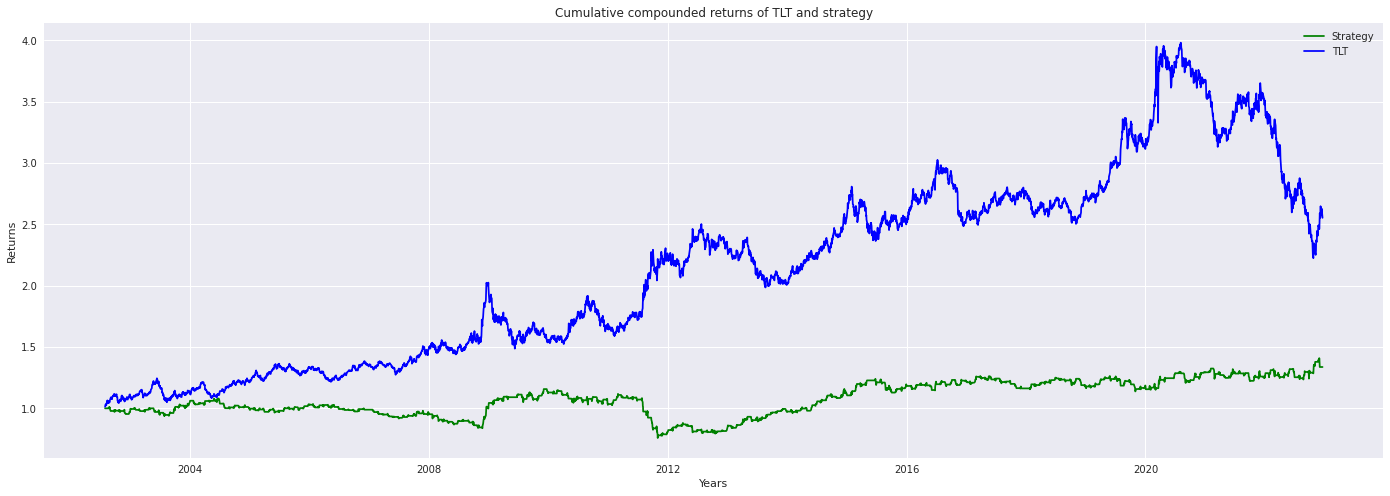

In [ ]:
plt.style.use("seaborn")
plt.figure(figsize = (24, 8))
plt.plot(df.index, df["equity_cr"], c = "g", label = "Strategy")
plt.plot(df.index, df["TLT_cr"], c = "b", label = "TLT")
plt.xlabel("Years")
plt.ylabel("Returns")
plt.legend()
plt.title("Cumulative compounded returns of TLT and strategy")

In [ ]:
# Annualized sharpe ratios:

df["TLT_sharpe"] = (df["TLT_pc"].rolling(1000).mean() / df["TLT_pc"].rolling(1000).std()) * np.sqrt(252)
df["equity_sharpe"] = (df["equity_pc"].rolling(1000).mean() / df["TLT_pc"].rolling(1000).std()) * np.sqrt(252)

Text(0.5, 1.0, '4-year rolling annualized sharpe ratio of TLT and strategy')

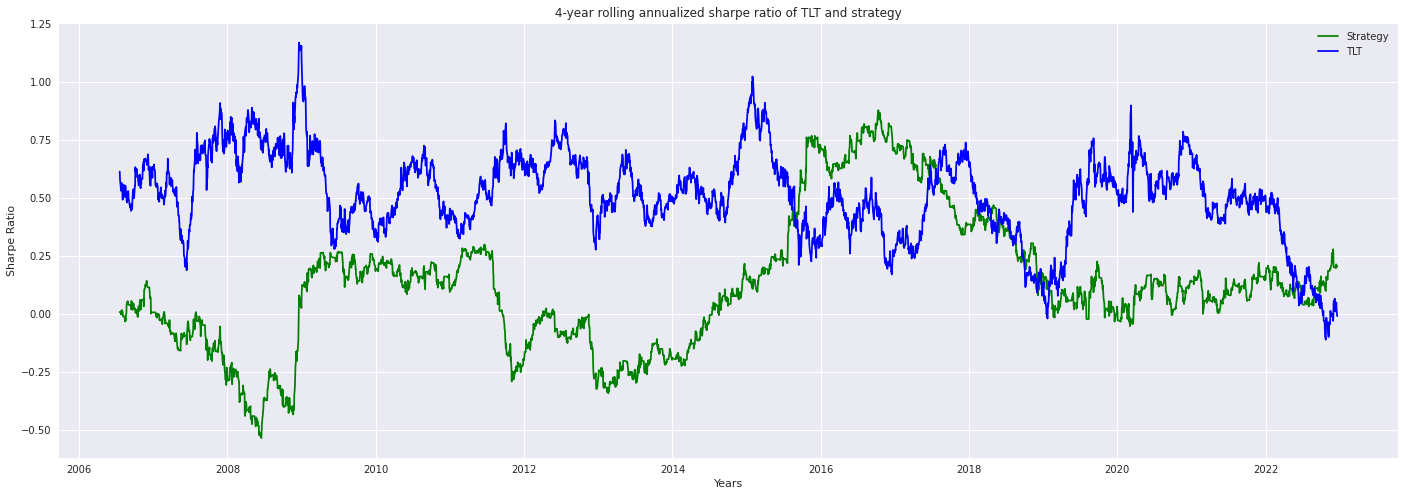

In [ ]:
plt.style.use("seaborn")
plt.figure(figsize = (24, 8))
plt.plot(df.index, df["equity_sharpe"], c = "g", label = "Strategy")
plt.plot(df.index, df["TLT_sharpe"], c = "b", label = "TLT")
plt.xlabel("Years")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.title("4-year rolling annualized sharpe ratio of TLT and strategy")

Text(0.5, 1.0, '1-year rolling correlation between TLT and Strategy')

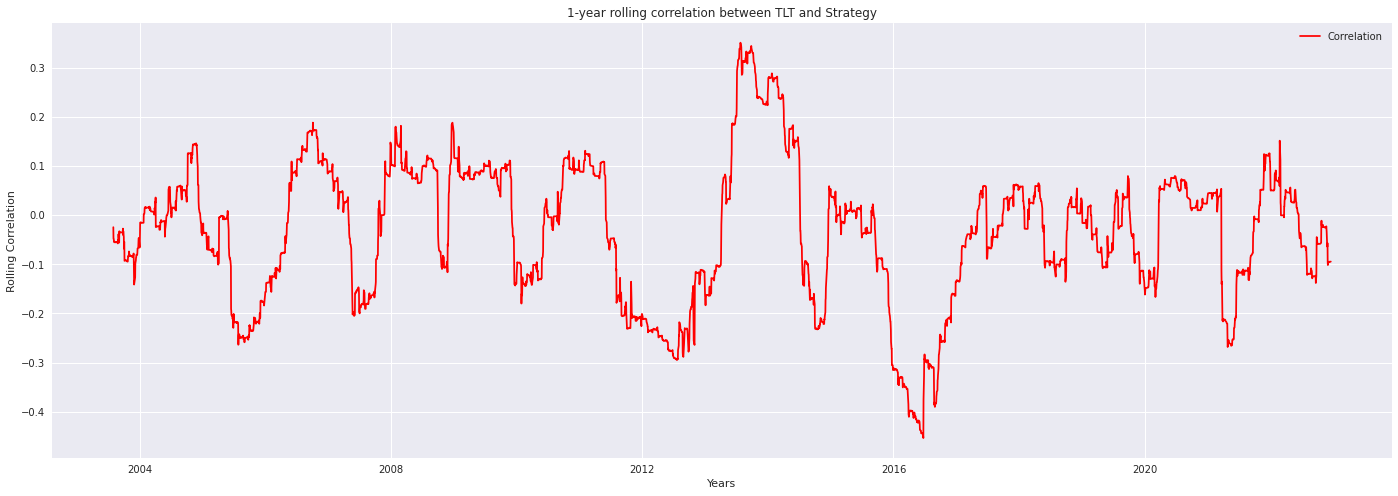

In [ ]:
df["corr"] = df['equity_pc'].rolling(252).corr(df['TLT_pc'])  # Rolling 1 year correlation between TLT and strategy gains.

plt.style.use("seaborn")
plt.figure(figsize = (24, 8))
plt.plot(df.index, df["corr"], c = "r", label = "Correlation")
plt.xlabel("Years")
plt.ylabel("Rolling Correlation")
plt.legend()
plt.title("1-year rolling correlation between TLT and Strategy")